# Outlier Detection

Outliers are anomolous points within a dataset. They are points that don't fit within the normal or expected statistical distribution of the dataset and can occur for a variety of reasons such as sensor and measurement errors, poor data sampling techniques and unexpected events. The figure below from McDonald (2021) illustrates an outlier, highlighted in red, within a porosity-permeability dataset.

<img src="figures/OutlierXplot.png" alt="Outlier Crossplot" width="300"/>

Within well logs, outliers can occur due washed out boreholes, tool and sensor issues, rare geological features, and issues in the data acquistion process. It is essential that these outliers are identified and investigated early on in the workflow as they can result in inaccurate predictions by machine learning models.

There are a number of ways to identify outliers within a dataset, some of these are visual such as scatterplots (crossplots) and boxplots, whilst other rely on statistical methods (Z-score) or even unsupervised machine learning algorithms (K Nearest Neighbours). 

Detecting Outliers in the Volve Dataset:
- Z-Score
- Box Plot and IQR
- Using a Caliper Curve
- Automated Outlier Detection

## Importing Libraries & Data

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

In [33]:
df = pd.read_csv('data\spwla_volve_data.csv')

An initial look at `describe()` function of pandas allows us to see the data range (min and max) for output.

In [34]:
df.describe()

,MD,BS,CALI,DT,DTS,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
count,27845.000000,27845.0,27845.000000,5493.000000,5420.000000,27845.000000,27845.000000,27845.000000,27845.000000,27845.000000,27845.000000,27600.000000,27736.000000,27736.000000,2.784400e+04
mean,3816.224960,8.5,8.625875,78.000104,131.027912,38.529140,0.188131,352.689922,97.558930,2.379268,1561.079977,30.041154,0.157434,0.531684,2.724204e-01
std,398.843662,0.0,0.079941,7.730495,13.230939,21.814711,0.053390,1367.355219,395.725094,0.162293,9570.308431,210.915588,0.075957,0.353637,1.872371e-01
min,3223.000000,8.5,8.304900,54.280000,83.574000,6.869100,0.024000,0.197400,0.234900,1.627000,0.139000,0.136600,0.001000,0.043000,1.820000e-15
25%,3503.000000,8.5,8.556900,72.562500,123.403425,21.128200,0.157000,1.856400,1.781000,2.240000,2.148300,1.884000,0.091000,0.201000,1.258000e-01
50%,3713.300000,8.5,8.625000,77.228000,131.864350,35.071000,0.183900,4.035800,3.681200,2.356000,5.136800,4.195400,0.178000,0.433000,2.400000e-01
75%,4057.000000,8.5,8.672000,84.342900,138.017500,49.178300,0.215200,14.929000,8.891000,2.502500,24.687400,14.782650,0.225000,1.000000,3.540000e-01
max,4744.000000,8.5,9.175000,96.277600,186.090800,127.055700,0.541000,6381.099100,2189.603000,3.090000,62290.770000,5571.435100,0.292000,1.000000,1.000000e+00


### Convert Logathrithmic Curves

In [35]:
res_curves = ['RACEHM', 'RACELM', 'RPCEHM', 'RPCELM']

for res in res_curves:
    df[f'{res}_l10'] = np.log10(df[res])
    df.drop(columns=[res],inplace=True)
    
df.head()

,wellName,MD,BS,CALI,DT,DTS,GR,NPHI,RHOB,PHIF,SW,VSH,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10
0,15/9-F-1 A,3431.0,8.5,8.6718,86.9092,181.2241,53.9384,0.3222,2.7514,0.02,1.0,0.6807,-0.293794,-0.072784,-0.189700,-0.189297
1,15/9-F-1 A,3431.1,8.5,8.6250,86.4334,181.1311,57.2889,0.3239,2.7978,0.02,1.0,0.7316,-0.328364,-0.089109,-0.122456,-0.182435
2,15/9-F-1 A,3431.2,8.5,8.6250,85.9183,180.9487,59.0455,0.3277,2.8352,0.02,1.0,0.7583,-0.299989,-0.094312,-0.059583,-0.163803
3,15/9-F-1 A,3431.3,8.5,8.6250,85.3834,180.7211,58.2550,0.3357,2.8557,0.02,1.0,0.7462,-0.218388,-0.097779,-0.024522,-0.101659
4,15/9-F-1 A,3431.4,8.5,8.6250,84.8484,180.4930,59.4569,0.3456,2.8632,0.02,1.0,0.7646,-0.147825,-0.108909,0.016365,-0.058986


From the above table, we can observe that a number of the means (e.g. DTS) are unusually low. On closer inspection, we can observe that the minimum value for a number of curves is `-9999.000000` which is a commonly used value to represent null data.

In the previous notebook (1.1 - Missing Data) we replaced these null values using the command below. If we apply this method here, we should be able to get a clearer picture of the state of the data.

We can now see that the `-9999.0` values have been removed. The next values that are of possible concern are the resistivity values, which are extremely high and warrant further investigation.

### Boxplots
Boxplots are a visual tool for identifying outliers within a dataset.......

The simplest method for calling a boxplot is using `.plot(kind='box)` on the dataframe. However, as you will see, this will plot all of the columns on one scale. This allows you to see curves which have a larger range, but it obscures those with a smaller range such as VSH.

C:\Users\BANAMZ\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


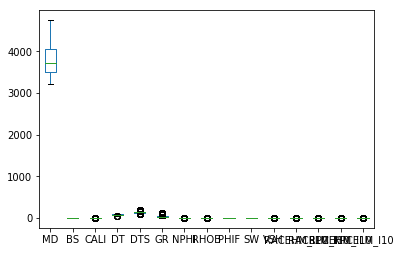

In [36]:
df.plot(kind='box')
plt.show()

To make the plots easier to view and understand, we can call upon the boxplot from the seaborn library and loop over each of the columns in the dataframe.

In [37]:
def make_boxplot(welldata, inputs):

    num_inputs = len(inputs)

    fig, axs = plt.subplots(1, num_inputs, figsize=(20,10))

    for i, (ax, curve) in enumerate(zip(axs.flat, inputs), 1):
        sns.boxplot(y=welldata[curve], ax=ax, color='cornflowerblue', showmeans=True,  
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
               flierprops={'marker':'o', 
                          'markerfacecolor':'darkgreen',
                          'markeredgecolor':'darkgreen'})
        
        ax.set_title(inputs[i-1])
        ax.set_ylabel('')

    plt.subplots_adjust(hspace=0.15, wspace=1.25)
    plt.show()

In [38]:
import matplotlib
def make_xplot(welldata, xvar, yvar,  color, rows=1, cols=1, xscale=[0,1], yscale=[0,1], vmin=0, vmax=1):
    fig, axs = plt.subplots(rows, cols, figsize=(20,10))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    
    for (name, welldata), ax in zip(grouped, axs.flat):
        sc = ax.scatter(x=xvar, y=yvar, data=welldata, c=color, vmin=vmin, vmax=vmax, cmap=cmap)
#         sns.scatterplot(x=xvar, y=yvar, data=welldata, hue=color, ax=ax, legend=False, palette="viridis")

        ax.set_ylim(yscale[0], yscale[1])
        ax.set_xlim(xscale[0], xscale[1])
        ax.set_ylabel(yvar)
        ax.set_xlabel(xvar)
        ax.set_title(name)
        
        fig.colorbar(sc, ax=ax)

    plt.show()

['MD', 'BS', 'CALI', 'DT', 'DTS', 'GR', 'NPHI', 'RHOB', 'PHIF', 'SW', 'VSH', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10']
Total Number of Samples: 27845


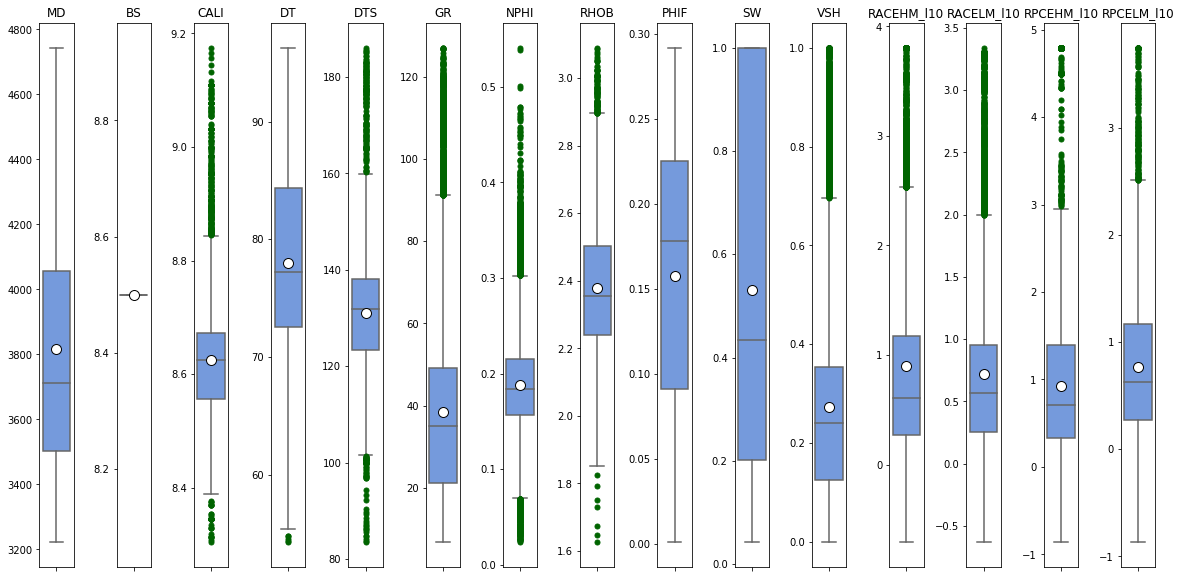

In [39]:
inputs = list(df.columns)
inputs.pop(0) # remove the well name from the columns list
print(inputs)
print(f'Total Number of Samples: {len(df)}')
make_boxplot(df, inputs)

In [8]:
grouped = df.groupby('wellName')

In [ ]:
make_xplot(grouped, 'NPHI', 'RHOB', 'CALI', 2, 3, [-0.15, 0.6], [3.5,1.5], 8.5, 9)

In [40]:
df = df[(df['CALI'] >= 8.5) & (df['CALI'] <= 9)]
df.describe()

,MD,BS,CALI,DT,DTS,GR,NPHI,RHOB,PHIF,SW,VSH,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10
count,26852.000000,26852.0,26852.000000,5489.000000,5416.000000,26852.000000,26852.000000,26852.000000,26743.000000,26743.000000,26851.000000,26852.000000,26852.000000,26852.000000,26607.000000
mean,3830.589386,8.5,8.630104,77.996008,131.023411,38.770505,0.186842,2.380871,0.156234,0.526250,0.274255,0.927585,0.743429,0.956627,0.791878
std,396.631701,0.0,0.070989,7.731735,13.234529,21.913592,0.053268,0.162784,0.075732,0.356385,0.187989,0.969912,0.756417,0.911617,0.659487
min,3223.000000,8.5,8.500000,54.280000,83.574000,7.008700,0.024000,1.627000,0.001000,0.043000,0.000100,-0.704653,-0.629117,-0.856985,-0.864549
25%,3521.775000,8.5,8.578000,72.554300,123.392375,21.315750,0.156700,2.240675,0.090000,0.195150,0.127000,0.283075,0.268344,0.353339,0.293705
50%,3725.850000,8.5,8.625000,77.224600,131.847750,35.310650,0.182000,2.362000,0.175400,0.419000,0.241900,0.627033,0.590340,0.726829,0.645717
75%,4072.725000,8.5,8.672000,84.342900,138.006900,49.536775,0.213800,2.504200,0.224000,1.000000,0.357000,1.207466,0.966550,1.428613,1.206394
max,4744.000000,8.5,9.000000,96.277600,186.090800,127.055700,0.541000,3.090000,0.292000,1.000000,1.000000,3.804895,3.340365,4.794424,3.745967


In [28]:
# z_score_cols = ['CALI', 'DT','DTS', 'GR', 'NPHI', 'RACEHM', 'RACELM', 'RHOB','RPCEHM', 'RPCELM']
# # zscore = lambda x: (x - x.mean()) / x.std()


# for col in z_score_cols:
#     df[f'{col}_zscore'] = df[col].groupby(df['wellName']).transform(lambda x: (x - x.mean()) / x.std())
# df

In [29]:
df.columns

Index(['wellName', 'MD', 'BS', 'CALI', 'DT', 'DTS', 'GR', 'NPHI', 'RHOB',
       'PHIF', 'SW', 'VSH', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10',
       'RPCELM_l10'],
      dtype='object')

In [41]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

anomaly_df = df[['wellName', 'MD', 'CALI', 'GR', 'NPHI', 'RHOB', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10', 'PHIF', 'SW', 'VSH']].copy()
anomaly_df.dropna(inplace=True)

anomaly_inputs = ['NPHI', 'RHOB', 'CALI', 'GR']

model_IF = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), max_features=1.0, random_state=42)
model_SVM = OneClassSVM(nu=0.10)
model_lof = LocalOutlierFactor(contamination=0.1, novelty=True)

models = {'IF':model_IF, 
         'SVM': model_SVM,
         'LOF': model_lof}

for name, model in models.items():
    print(f'Fitting: {name}')
    model.fit(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly_scores'] = model.decision_function(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly'] = model.predict(anomaly_df[anomaly_inputs])
anomaly_df.head(5)

Fitting: IF


C:\Users\BANAMZ\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\BANAMZ\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Fitting: SVM


C:\Users\BANAMZ\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fitting: LOF


,wellName,MD,CALI,GR,NPHI,RHOB,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10,PHIF,SW,VSH,IF_anomaly_scores,IF_anomaly,SVM_anomaly_scores,SVM_anomaly,LOF_anomaly_scores,LOF_anomaly
0,15/9-F-1 A,3431.0,8.6718,53.9384,0.3222,2.7514,-0.293794,-0.072784,-0.189700,-0.189297,0.02,1.0,0.6807,-0.077212,-1,0.141081,1,-0.086709,-1
1,15/9-F-1 A,3431.1,8.6250,57.2889,0.3239,2.7978,-0.328364,-0.089109,-0.122456,-0.182435,0.02,1.0,0.7316,-0.106547,-1,-0.641214,-1,-0.408201,-1
2,15/9-F-1 A,3431.2,8.6250,59.0455,0.3277,2.8352,-0.299989,-0.094312,-0.059583,-0.163803,0.02,1.0,0.7583,-0.116009,-1,-1.061292,-1,-0.468474,-1
3,15/9-F-1 A,3431.3,8.6250,58.2550,0.3357,2.8557,-0.218388,-0.097779,-0.024522,-0.101659,0.02,1.0,0.7462,-0.123584,-1,-1.182163,-1,-0.476047,-1
4,15/9-F-1 A,3431.4,8.6250,59.4569,0.3456,2.8632,-0.147825,-0.108909,0.016365,-0.058986,0.02,1.0,0.7646,-0.127021,-1,-1.571748,-1,-0.717891,-1


Outlier Method: IF
Number of anomalous values 2650
Number of non anomalous values  23848
Total Number of Values: 26498
Outlier Method: SVM
Number of anomalous values 2660
Number of non anomalous values  23838
Total Number of Values: 26498
Outlier Method: LOF
Number of anomalous values 2372
Number of non anomalous values  24126
Total Number of Values: 26498


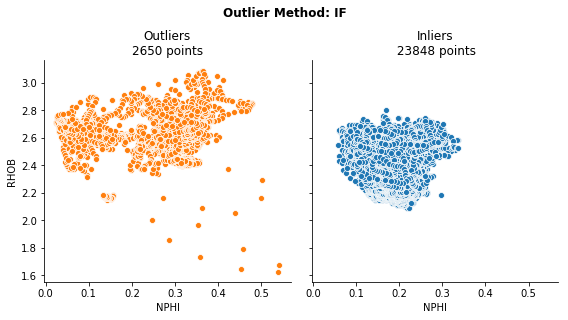

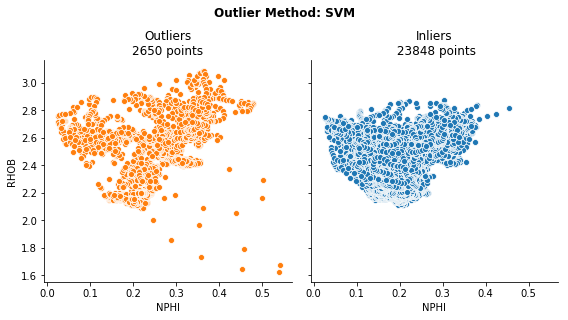

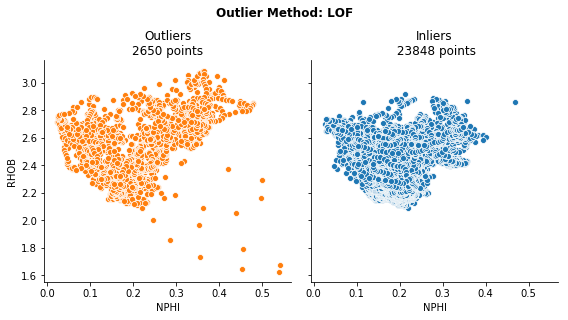

In [42]:
for name in models.keys():
    print(f'Outlier Method: {name}')
    method = f'{name}_anomaly'
    print(f"Number of anomalous values {len(anomaly_df[anomaly_df[method]==-1])}")
    print(f"Number of non anomalous values  {len(anomaly_df[anomaly_df[method]== 1])}")
    print(f'Total Number of Values: {len(anomaly_df)}')

    g = sns.FacetGrid(anomaly_df, col=method, height=4, hue=method, hue_order=[1,-1])
    g.map(sns.scatterplot, 'NPHI', 'RHOB')
    g.fig.suptitle(f'Outlier Method: {name}', y=1.10, fontweight='bold')

    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(anomaly_df[anomaly_df['IF_anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(anomaly_df[anomaly_df['IF_anomaly']==  1])} points")

plt.show()

In [26]:
df['wellName']

0       15/9-F-1 A
1       15/9-F-1 A
2       15/9-F-1 A
3       15/9-F-1 A
4       15/9-F-1 A
           ...    
2096    15/9-F-1 A
2097    15/9-F-1 A
2098    15/9-F-1 A
2099    15/9-F-1 A
2100    15/9-F-1 A
Name: wellName, Length: 2101, dtype: object

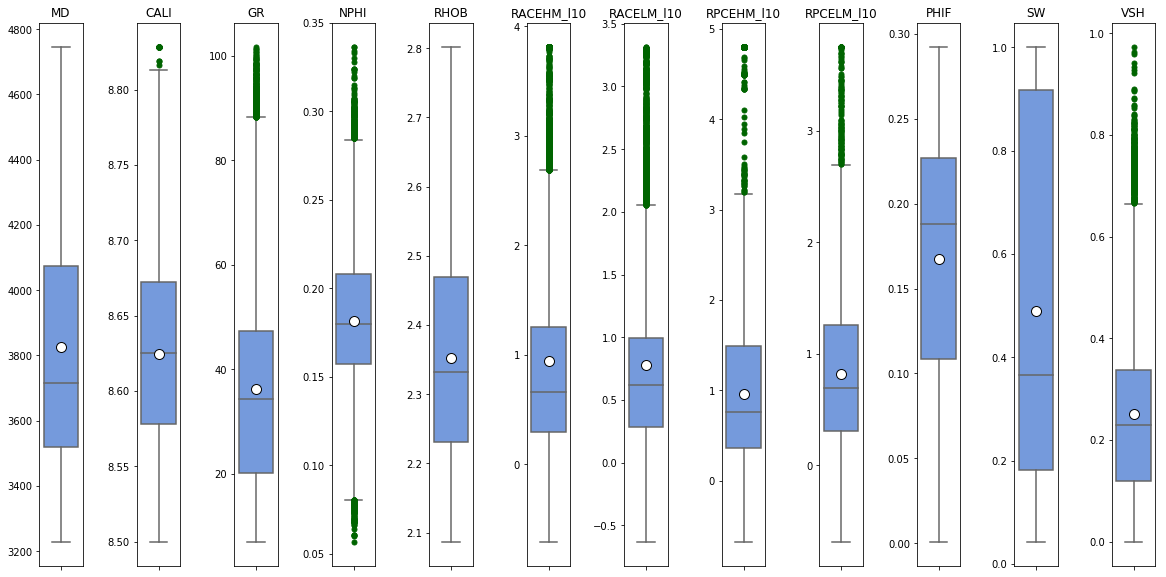

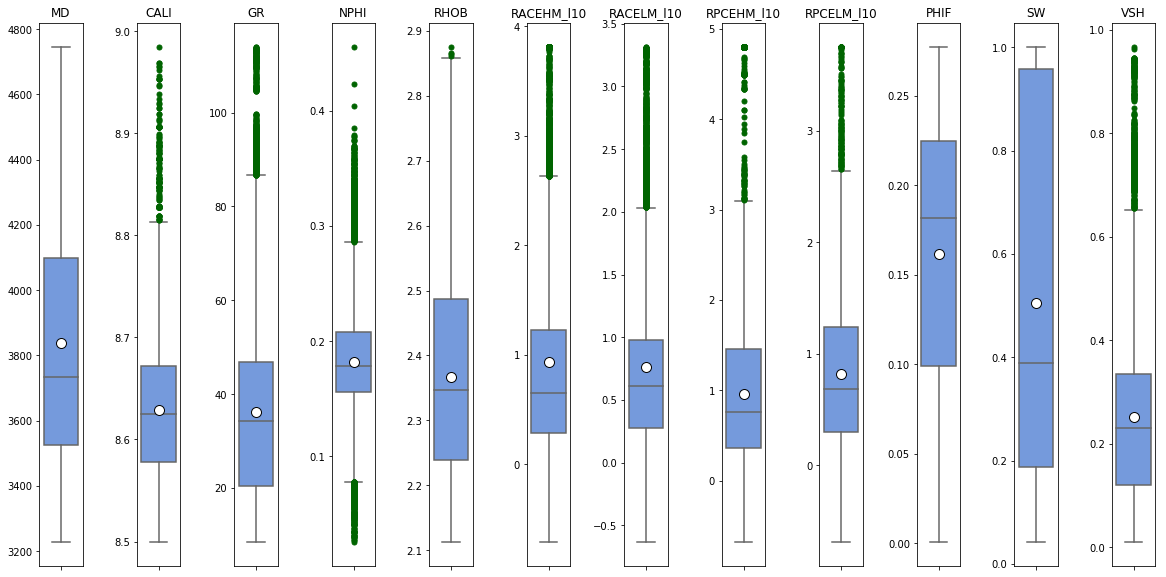

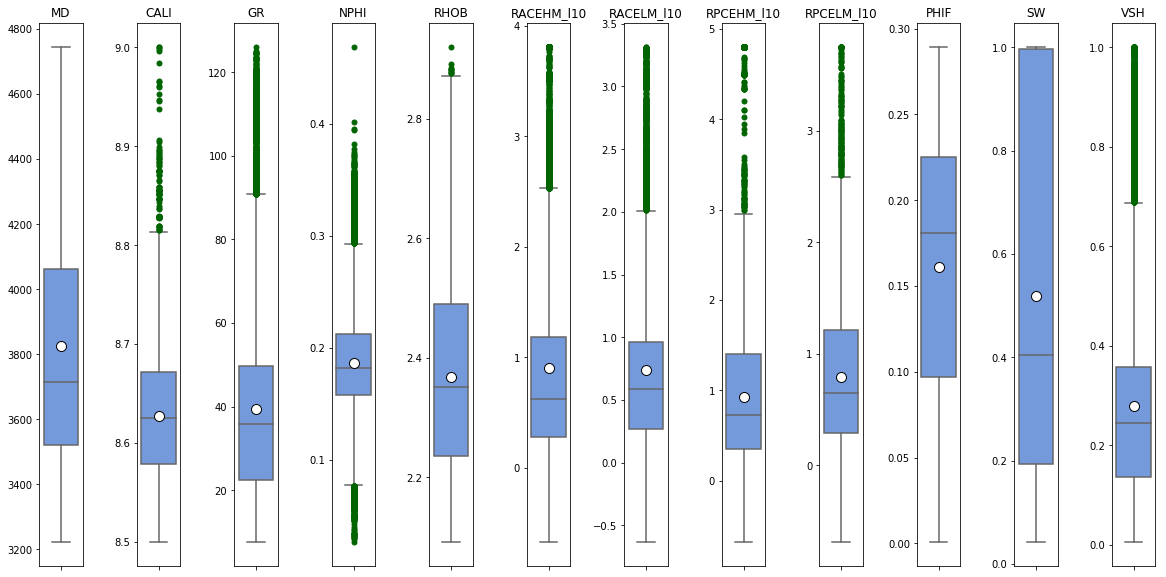

In [49]:
for name in models.keys():
    mask = anomaly_df[f'{name}_anomaly'] != -1
    clean_df = anomaly_df[mask]
    inputs = list(anomaly_df.columns)
    inputs = inputs[1:-6]

#     print(f'Total Number of Samples: {len(clean_df)}')
    make_boxplot(clean_df, inputs)

Outlier Method: IF
Number of anomalous values 2650
Number of non anomalous values  23848
Total Number of Values: 26498
Outlier Method: SVM
Number of anomalous values 2660
Number of non anomalous values  23838
Total Number of Values: 26498
Outlier Method: LOF
Number of anomalous values 2372
Number of non anomalous values  24126
Total Number of Values: 26498


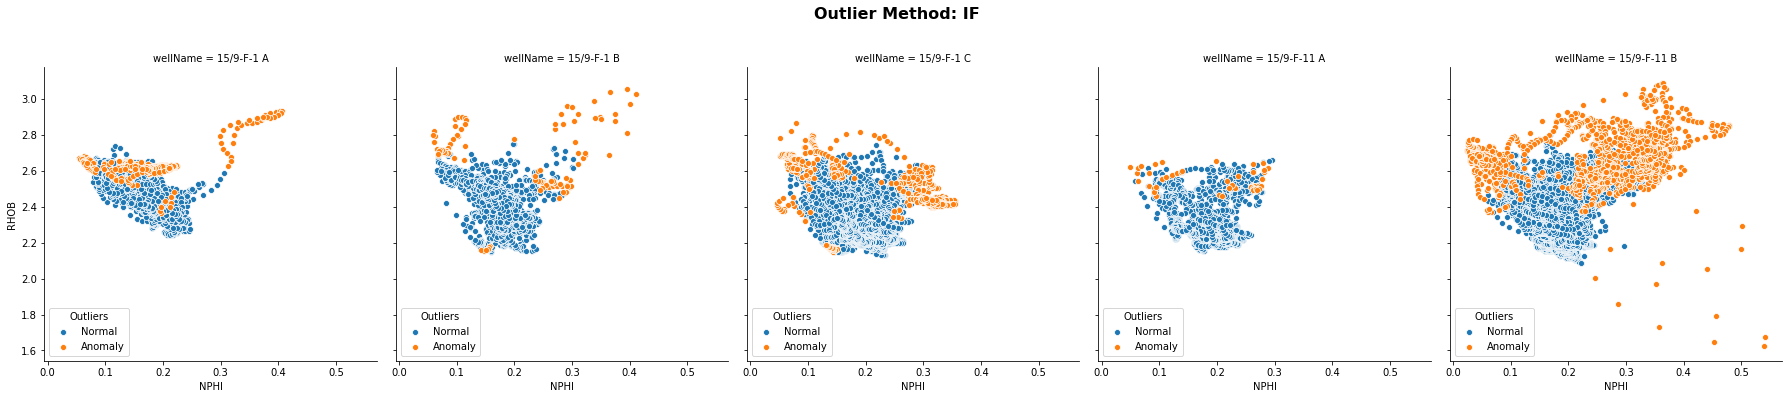

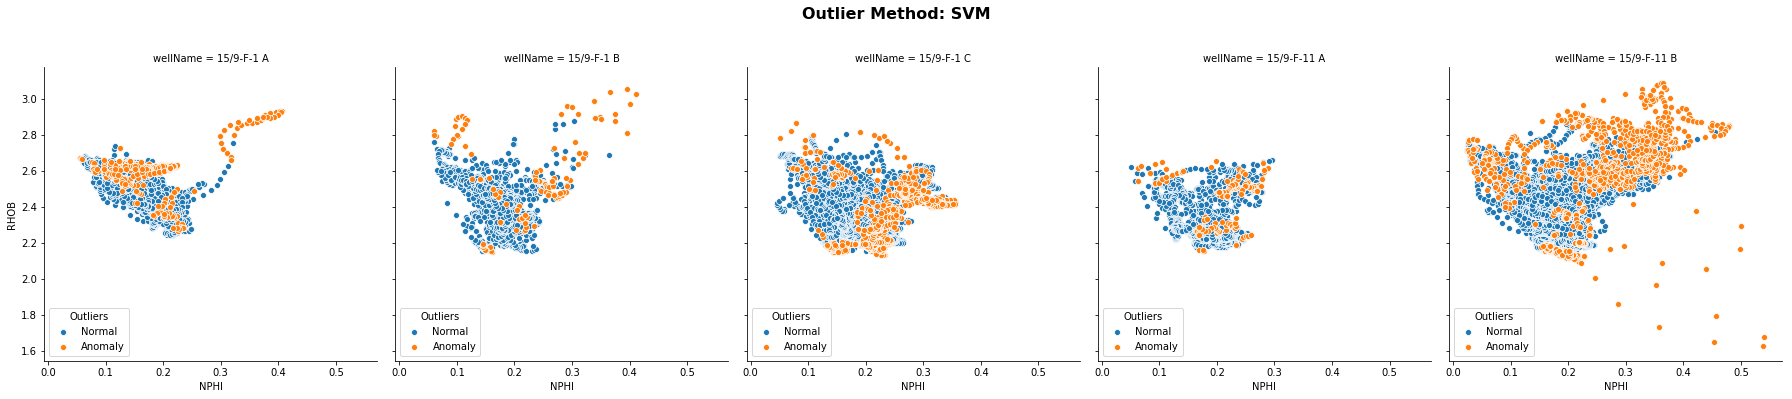

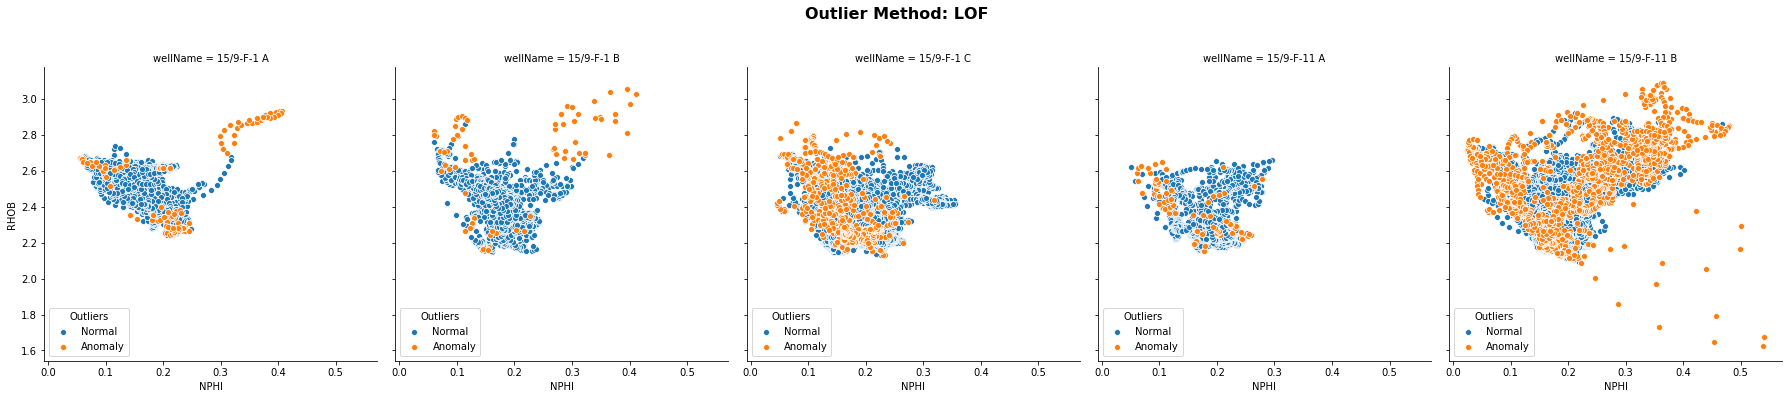

In [44]:
for name in models.keys():
    print(f'Outlier Method: {name}')
    method = f'{name}_anomaly'
    print(f"Number of anomalous values {len(anomaly_df[anomaly_df[method]==-1])}")
    print(f"Number of non anomalous values  {len(anomaly_df[anomaly_df[method]== 1])}")
    print(f'Total Number of Values: {len(anomaly_df)}')

    g = sns.FacetGrid(anomaly_df, col='wellName', hue=method, height=5, hue_order=[1,-1])
    g.map(sns.scatterplot, 'NPHI', 'RHOB')
    
    g.fig.suptitle(f'Outlier Method: {name}', y=1.10, fontweight='bold', fontsize=16)

    axes = g.axes.flatten()
    for ax in axes:
        ax.legend(title='Outliers', loc='lower left', labels=['Normal', 'Anomaly'])

plt.show()


In [45]:
anomaly_df['CALI']

0        8.6718
1        8.6250
2        8.6250
3        8.6250
4        8.6250
          ...  
27840    8.8750
27841    8.8510
27842    8.8040
27843    8.7260
27844    8.6720
Name: CALI, Length: 26498, dtype: float64

In [46]:
temp_df = anomaly_df.loc[anomaly_df['IF_anomaly'] == 1]
output_df = temp_df[['wellName', 'MD', 'CALI', 'GR', 'RHOB', 'NPHI', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10',
                    'PHIF', 'SW', 'VSH']]


In [47]:
output_df.describe()

,MD,CALI,GR,RHOB,NPHI,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10,PHIF,SW,VSH
count,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000,23848.000000
mean,3824.990154,8.624288,36.134537,2.352930,0.181817,0.939053,0.775713,0.953832,0.821686,0.167671,0.489861,0.250313
std,393.640138,0.063746,18.335030,0.139029,0.039879,0.951391,0.782331,0.866506,0.668946,0.069769,0.347864,0.155924
min,3229.600000,8.500000,7.008700,2.087000,0.057000,-0.704653,-0.629117,-0.675923,-0.682564,0.001000,0.043000,0.000100
25%,3520.500000,8.578000,20.152025,2.230900,0.157000,0.294676,0.283301,0.355404,0.305109,0.108300,0.181000,0.118900
50%,3714.800000,8.625000,34.286450,2.331450,0.179600,0.660685,0.616911,0.757529,0.689828,0.188000,0.365850,0.230000
75%,4073.525000,8.672000,47.403775,2.470000,0.208000,1.249935,0.991994,1.485008,1.260885,0.227000,0.918275,0.337500
max,4744.000000,8.828000,101.633400,2.801000,0.336000,3.804895,3.311054,4.794424,3.745967,0.292000,1.000000,0.972000


In [48]:
output_df.to_pickle('IF_cleaned_data.pkl')